## Treshold 0.3
### IoU PraNet = 0.4924

In [5]:
import os
import torch
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
from lib.PraNet_Res2Net import PraNet
import segmentation_models_pytorch as smp

unet_model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
)

IMAGE_DIR = 'c:/Users/Dara/PraNet/Images'
MASK_DIR = 'c:/Users/Dara/PraNet/Masks'
OUTPUT_DIR_PRANET = 'c:/Users/Dara/PraNet/pranet_results_EITS'
OUTPUT_DIR_UNET = 'c:/Users/Dara/uNet/unet_results_EITS'

TENSORBOARD_LOG_DIR_PRANET = 'c:/Users/Dara/PraNet/logs/pranet_logs_EITS'
TENSORBOARD_LOG_DIR_UNET = 'c:/Users/Dara/uNet/logs/unet_logs_EITS'

os.makedirs(OUTPUT_DIR_PRANET, exist_ok=True)
os.makedirs(OUTPUT_DIR_UNET, exist_ok=True)
os.makedirs(TENSORBOARD_LOG_DIR_PRANET, exist_ok=True)
os.makedirs(TENSORBOARD_LOG_DIR_UNET, exist_ok=True)

def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.images[idx])
    mask_path = os.path.join(self.mask_dir, self.masks[idx])

    # Verify files exist
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image file not found: {img_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask file not found: {mask_path}")

    try:
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not read image file: {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None:
            raise ValueError(f"Could not read mask file: {mask_path}")
            
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        if self.transform:
            image = self.transform(image)
            mask = cv2.resize(mask, (352, 352), interpolation=cv2.INTER_NEAREST)

        return image, mask, self.images[idx]
    except Exception as e:
        print(f"Error processing image {img_path} or mask {mask_path}: {str(e)}")
        raise

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((352, 352)),
])

val_dataset = PolypDataset(IMAGE_DIR, MASK_DIR, transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

def calculate_metrics(pred, true):
    pred_flat = pred.flatten()
    true_flat = true.flatten()

    iou = jaccard_score(true_flat, pred_flat)
    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)

    return iou, precision, recall, f1

def evaluate_model(model, model_name, output_dir, tensorboard_log_dir):
    writer = SummaryWriter(log_dir=tensorboard_log_dir)
    iou_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

    for img, mask, img_name in tqdm(val_loader, desc=f'Evaluating {model_name}'):
        with torch.no_grad():
            if model_name == 'PraNet':
                pred = model(img)[0]
            else:
                pred = model(img)
            pred_mask = pred.squeeze().cpu().numpy()
            pred_mask = (pred_mask > 0.3).astype(np.uint8)

        iou, precision, recall, f1 = calculate_metrics(pred_mask, mask.numpy().squeeze())
        iou_scores.append(iou)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        pred_mask_img = (pred_mask * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_dir, img_name[0]), pred_mask_img)

    avg_iou = np.mean(iou_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    print(
        f'{model_name} Evaluation:\n'
        f'IoU: {avg_iou:.4f}, Precision: {avg_precision:.4f}, '
        f'Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}\n'
    )

    writer.add_scalar(f'IoU', avg_iou)
    writer.add_scalar(f'Precision', avg_precision)
    writer.add_scalar(f'Recall', avg_recall)
    writer.add_scalar(f'F1-Score', avg_f1)
    writer.close()

pranet_model = PraNet()
pranet_model.load_state_dict(torch.load('C:/Users/Dara/PraNet/praNet.pth', map_location='cpu'))
pranet_model.eval()
evaluate_model(pranet_model, 'PraNet', OUTPUT_DIR_PRANET, TENSORBOARD_LOG_DIR_PRANET)


unet_model.load_state_dict(torch.load('c:/Users/Dara/PraNet/Unet.pth', map_location='cpu'))
unet_model.eval()
evaluate_model(unet_model, 'UNet', OUTPUT_DIR_UNET, TENSORBOARD_LOG_DIR_UNET)


Evaluating PraNet:   1%|          | 2/196 [00:00<01:05,  2.98it/s]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating PraNet:   3%|▎         | 5/196 [00:01<01:03,  3.02it/s]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating PraNet:  13%|█▎        | 25/196 [00:08<00:55,  3.08it/s]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defi

PraNet Evaluation:
IoU: 0.4924, Precision: 0.5910, Recall: 0.5817, F1-Score: 0.5612



Evaluating UNet:   1%|          | 2/196 [00:00<00:33,  5.84it/s]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating UNet:   2%|▏         | 3/196 [00:00<00:32,  5.99it/s]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating UNet:   2%|▏         | 4/196 [00:00<00:33,  5.79it/s]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and

UNet Evaluation:
IoU: 0.4084, Precision: 0.4682, Recall: 0.5745, F1-Score: 0.4882



## Treshold = np.linspace(0, 1, 256) 
### mean IoU PraNet = 0.4919

In [1]:
import os
import torch
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
from lib.PraNet_Res2Net import PraNet
import segmentation_models_pytorch as smp


IMAGE_DIR = 'c:/Users/Dara/PraNet/Images'
MASK_DIR = 'c:/Users/Dara/PraNet/Masks'
OUTPUT_DIR_PRANET = 'c:/Users/Dara/PraNet/pranet_results_EITS'
OUTPUT_DIR_UNET = 'c:/Users/Dara/uNet/unet_results_EITS'
TENSORBOARD_LOG_DIR_PRANET = 'c:/Users/Dara/PraNet/logs/pranet_logs_EITS'
TENSORBOARD_LOG_DIR_UNET = 'c:/Users/Dara/uNet/logs/unet_logs_EITS'


os.makedirs(OUTPUT_DIR_PRANET, exist_ok=True)
os.makedirs(OUTPUT_DIR_UNET, exist_ok=True)
os.makedirs(TENSORBOARD_LOG_DIR_PRANET, exist_ok=True)
os.makedirs(TENSORBOARD_LOG_DIR_UNET, exist_ok=True)

class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        if self.transform:
            image = self.transform(image)
            mask = cv2.resize(mask, (352, 352), interpolation=cv2.INTER_NEAREST)

        return image, mask, self.images[idx]

def evaluate_model(model, model_name, output_dir, log_dir):
    writer = SummaryWriter(log_dir=log_dir)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((352, 352)),
    ])
    
    dataset = PolypDataset(IMAGE_DIR, MASK_DIR, transform)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    thresholds = np.linspace(0, 1, 256)  
    metrics = {
        'IoU': np.zeros((len(dataset), len(thresholds))),
        'Precision': np.zeros((len(dataset), len(thresholds))),
        'Recall': np.zeros((len(dataset), len(thresholds))),
        'F1': np.zeros((len(dataset), len(thresholds)))
    }

    for i, (img, mask, img_name) in enumerate(tqdm(loader, desc=f'Evaluating {model_name}')):
        with torch.no_grad():
            pred = model(img)[0] if model_name == 'PraNet' else model(img)
            pred_prob = pred.squeeze().cpu().numpy()
        
        true_mask = mask.numpy().squeeze().astype(np.uint8)
        
        for j, th in enumerate(thresholds):
            pred_mask = (pred_prob > th).astype(np.uint8)
            
            metrics['IoU'][i, j] = jaccard_score(true_mask.flatten(), pred_mask.flatten())
            metrics['Precision'][i, j] = precision_score(true_mask.flatten(), pred_mask.flatten())
            metrics['Recall'][i, j] = recall_score(true_mask.flatten(), pred_mask.flatten())
            metrics['F1'][i, j] = f1_score(true_mask.flatten(), pred_mask.flatten())


    avg_metrics = {
        'IoU': np.mean(metrics['IoU']),
        'Precision': np.mean(metrics['Precision']),
        'Recall': np.mean(metrics['Recall']),
        'F1': np.mean(metrics['F1'])
    }


    for name, value in avg_metrics.items():
        writer.add_scalar(name, value)
    writer.close()

    print(f"\n{model_name} Average Metrics (256 thresholds):")
    print(f"IoU: {avg_metrics['IoU']:.4f}")
    print(f"Precision: {avg_metrics['Precision']:.4f}")
    print(f"Recall: {avg_metrics['Recall']:.4f}")
    print(f"F1: {avg_metrics['F1']:.4f}")



pranet_model = PraNet()
pranet_model.load_state_dict(torch.load('C:/Users/Dara/PraNet/praNet.pth', map_location='cpu'))
pranet_model.eval()
evaluate_model(pranet_model, 'PraNet', OUTPUT_DIR_PRANET, TENSORBOARD_LOG_DIR_PRANET)

# UNet
unet_model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
)
unet_model.load_state_dict(torch.load('c:/Users/Dara/PraNet/Unet.pth', map_location='cpu'))
unet_model.eval()
evaluate_model(unet_model, 'UNet', OUTPUT_DIR_UNET, TENSORBOARD_LOG_DIR_UNET)

Evaluating PraNet:   1%|          | 2/196 [00:13<22:13,  6.87s/it]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


PraNet Average Metrics (256 thresholds):
IoU: 0.4919
Precision: 0.5896
Recall: 0.5783
F1: 0.5605


Evaluating UNet:   0%|          | 0/196 [00:00<?, ?it/s]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating UNet:   1%|          | 1/196 [00:06<21:21,  6.57s/it]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating UNet:   1%|          | 2/196 [00:13<21:09,  6.54s/it]c:\Users\Dara\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s


UNet Average Metrics (256 thresholds):
IoU: 0.4058
Precision: 0.4657
Recall: 0.5733
F1: 0.4850


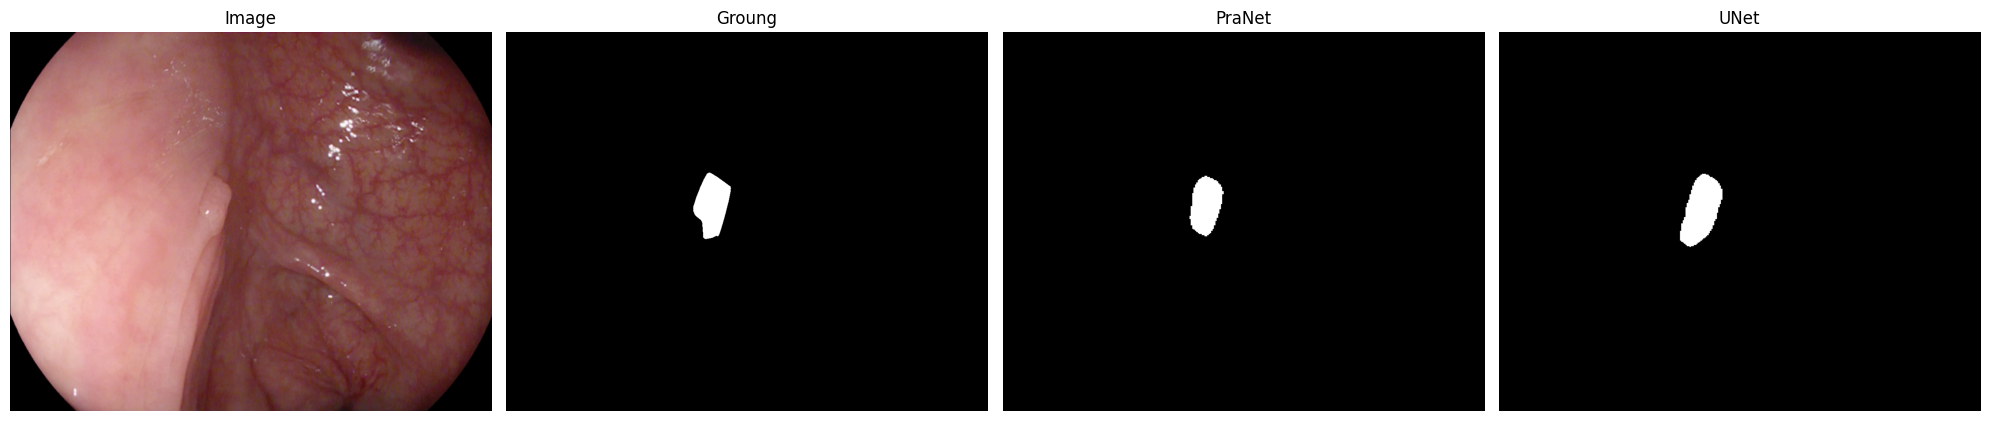

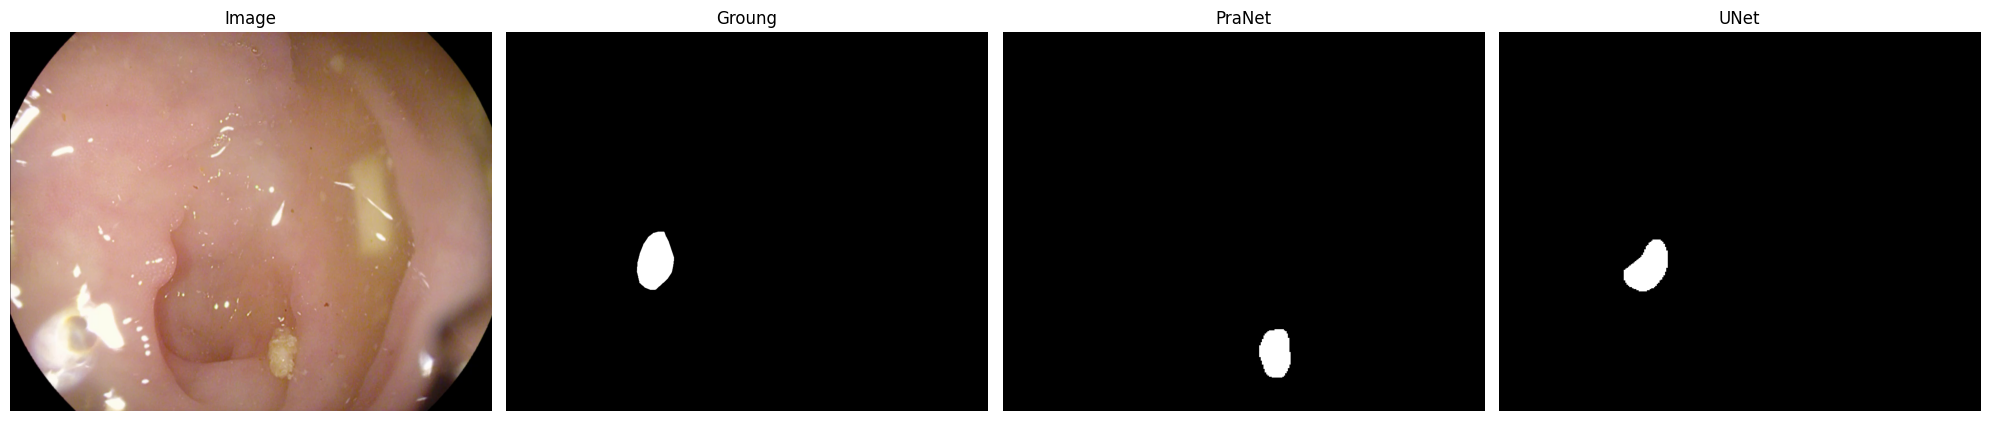

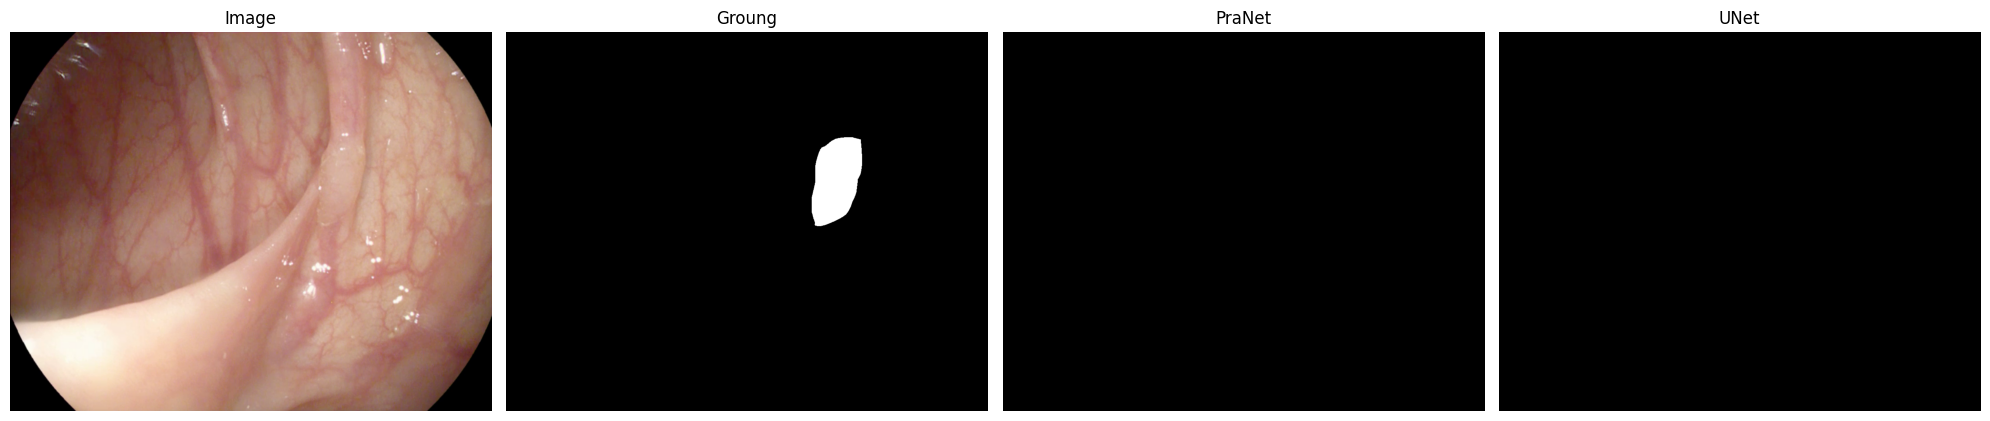

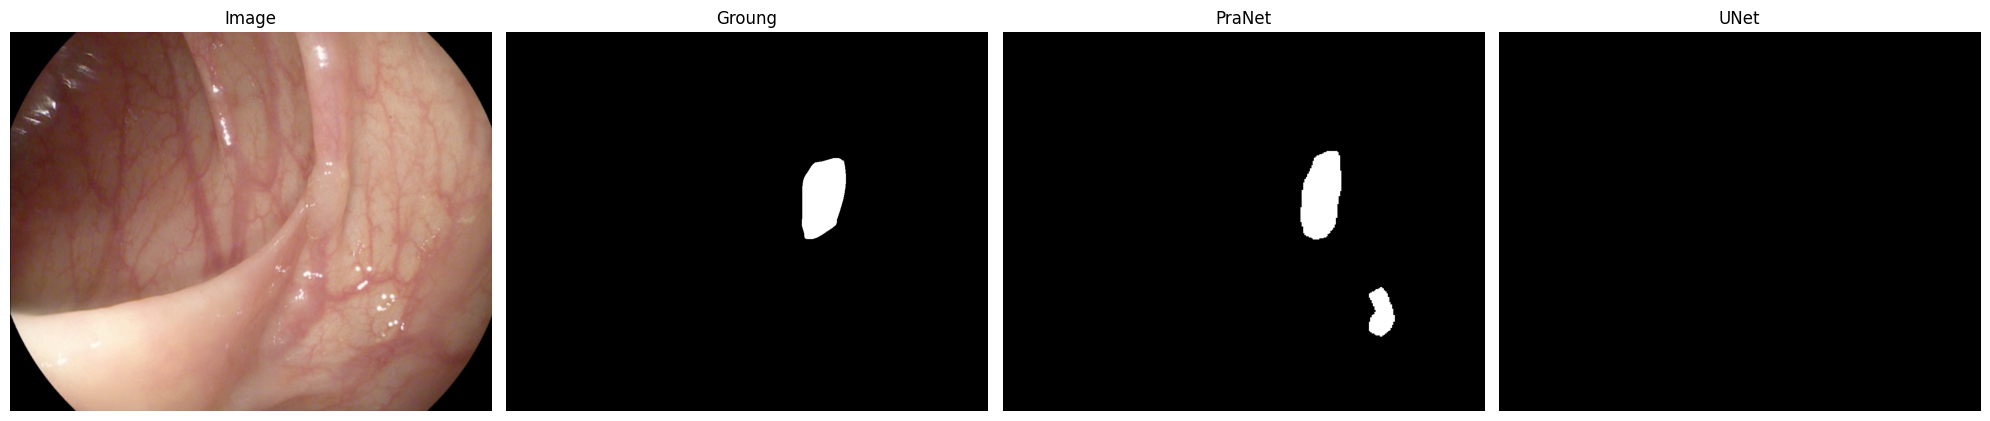

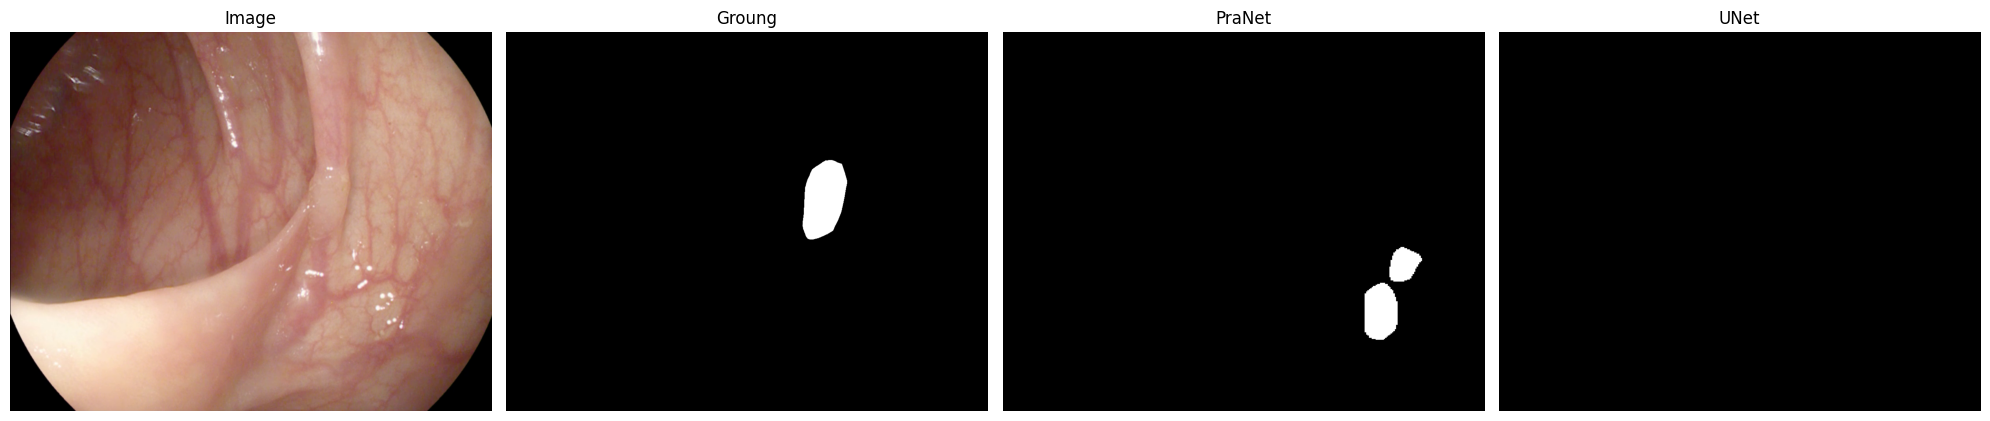

In [6]:
import matplotlib.pyplot as plt
image_files = sorted(os.listdir(IMAGE_DIR))

for image_name in image_files[:5]:
    image_path = os.path.join(IMAGE_DIR, image_name)
    mask_path = os.path.join(MASK_DIR, image_name)
    pranet_mask_path = os.path.join(OUTPUT_DIR_PRANET, image_name)
    unet_mask_path = os.path.join(OUTPUT_DIR_UNET, image_name)

    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    ideal_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    pranet_mask = cv2.imread(pranet_mask_path, cv2.IMREAD_GRAYSCALE)
    unet_mask = cv2.imread(unet_mask_path, cv2.IMREAD_GRAYSCALE)


    height, width = ideal_mask.shape
    pranet_mask_resized = cv2.resize(pranet_mask, (width, height), interpolation=cv2.INTER_NEAREST)
    unet_mask_resized = cv2.resize(unet_mask, (width, height), interpolation=cv2.INTER_NEAREST)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(ideal_mask, cmap='gray')
    axs[1].set_title('Groung')
    axs[1].axis('off')

    axs[2].imshow(pranet_mask_resized, cmap='gray')
    axs[2].set_title('PraNet')
    axs[2].axis('off')
    
    axs[3].imshow(unet_mask_resized, cmap='gray')
    axs[3].set_title('UNet')
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()
